In [406]:
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score, f1_score
from matplotlib import pyplot as plt
from tqdm import tqdm



In [407]:
np.random.seed(200)

Base class

In [408]:
class baseModel:
    def forward(self, x):
        pass

    def backward(self, output, learning_rate):
        pass

### Convolution: There will be four (hyper)parameters:
1. Number of output channels
2. Filter dimension
3. Stride
4. Padding

### Important Links
#### Backward
1. [conv backward dx](https://medium.com/@mayank.utexas/backpropagation-for-convolution-with-strides-8137e4fc2710)
2. [conv backward dw, db](https://medium.com/@mayank.utexas/backpropagation-for-convolution-with-strides-fb2f2efc4faa)
3. [conv implement](https://github.com/slvrfn/vectorized_convolution/blob/master/convolution.py?fbclid=IwAR1SFj7zg2banabtjIWb9Rjrww1rjuGX4CZ7u8UHGIH3BJHnaSkMnhx2jdU)

In [409]:
class ConvolutionLayer(baseModel):
    def __init__(self, output_channel, kernel_size, stride, padding):
        self.output_channel = output_channel
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.weights = None
        self.bias = None
        self.x = None
        self.window_arr = None

    def forward(self, x):
        self.x = x # batch_size, channel, height, width
        batch_size, channel, height, width = x.shape
        output_height = (height - self.kernel_size + 2 * self.padding) // self.stride + 1
        output_width = (width - self.kernel_size + 2 * self.padding) // self.stride + 1
        self.output = np.zeros((batch_size, self.output_channel,  output_height, output_width))
        if self.weights is None:
            # init weight with Xavier method
            self.weights = np.random.randn(self.output_channel, channel, self.kernel_size, self.kernel_size) * np.sqrt(2 / (channel * self.kernel_size * self.kernel_size))
            self.bias = np.zeros(self.output_channel)
        
        window_arr = np.lib.stride_tricks.as_strided(x, 
            shape=(batch_size, channel, output_height, output_width, self.kernel_size, self.kernel_size), 
            strides=(x.strides[0], x.strides[1], x.strides[2]*self.stride, x.strides[3]*self.stride, x.strides[2], x.strides[3]))

        self.window_arr = window_arr
        self.output = np.einsum('bihwkl,oikl->bohw', window_arr, self.weights) + self.bias[None, :, None, None]
        return self.output


    # backward prop vectorized
    def backward(self, output, learning_rate):
        
        x = self.x
        window_arr = self.window_arr
        dilate = self.stride - 1
        padding = self.kernel_size - 1 if self.padding == 0 else self.padding
        working_input = output

        # dilate the input if necessary
        if dilate != 0:
            working_input = np.insert(working_input, range(1, output.shape[2]), 0, axis=2)
            working_input = np.insert(working_input, range(1, output.shape[3]), 0, axis=3)

        # pad the input if necessary
        if padding != 0:
            working_input = np.pad(working_input, ((0,0), (0,0), (padding, padding), (padding, padding)), 'constant')

        in_batch, in_channel, out_height, out_width = x.shape
        out_batch, out_channel, _, _ = output.shape
        batch_str, channel_str, kern_h_str, kern_w_str = working_input.strides
        stride = 1

        window_arr_out = np.lib.stride_tricks.as_strided(
        working_input,
        (out_batch, out_channel, out_height, out_width, self.kernel_size, self.kernel_size),
        (batch_str, channel_str, stride*kern_h_str, stride*kern_w_str, kern_h_str, kern_w_str))

        rotated_kernel = np.rot90(self.weights, 2, axes=(2, 3))

        dx = np.einsum('bohwkl,oikl->bihw', window_arr_out, rotated_kernel)
        db = np.sum(output, axis=(0, 2, 3))
        dw = np.einsum('bihwkl,bohw->oikl', window_arr, output)
        
        self.weights -= learning_rate * dw
        self.bias -= learning_rate * db

        return dx
        

        
        

In [410]:
count = 1*1*5*5
input_arr = np.arange(-count/2, count/2).reshape(1, 1, 5, 5)
print(f'input: {input_arr}\n')
conv_layer = ConvolutionLayer(1, 3, 1, 0)
print(conv_layer)
output = conv_layer.forward(input_arr)
print(output.shape)
print(f'output--------\n{output}\n')

input: [[[[-12.5 -11.5 -10.5  -9.5  -8.5]
   [ -7.5  -6.5  -5.5  -4.5  -3.5]
   [ -2.5  -1.5  -0.5   0.5   1.5]
   [  2.5   3.5   4.5   5.5   6.5]
   [  7.5   8.5   9.5  10.5  11.5]]]]

(1, 1, 3, 3)
output--------
[[[[-5.39317786 -5.00821337 -4.62324888]
   [-3.46835542 -3.08339093 -2.69842644]
   [-1.54353298 -1.15856849 -0.773604  ]]]]



### ReLU: 

In [411]:
class ReLULayer(baseModel):
    def __init__(self):
        self.x = None

    def forward(self, x):
        self.x = x
        return np.maximum(0, x)

    def backward(self, output, learning_rate):
        self.output = output
        return self.output * (self.x > 0)
        

In [412]:
relu_layer = ReLULayer()
output = relu_layer.forward(output)
print(output.shape)
print(f'output--------\n{output}\n')

(1, 1, 3, 3)
output--------
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]]



### MaxPooling: There will be two parameters:
1. Filter dimension
2. Stride

### Important Links
#### Backward
1. [Maxpool Backward](https://stackoverflow.com/questions/61954727/max-pooling-backpropagation-using-numpy?fbclid=IwAR2PkO13F1_Jy99n5fysZD_dvHvqYQTPqno8Z-CLVt2-P664zjU1omJxMsQ)

In [413]:
class MaxPoolingLayer(baseModel):
    def __init__(self, pool_size, stride):
        self.pool_size = pool_size
        self.stride = stride
        self.x = None

    def forward(self, x):
        self.x = x
        batch_size, channel, height, width = x.shape
        output_height = (height - self.pool_size) // self.stride + 1
        output_width = (width - self.pool_size) // self.stride + 1
        self.output = np.zeros((batch_size, channel, output_height, output_width))
        
        # maxpooling without loop
        window_arr = np.lib.stride_tricks.as_strided(x, 
            shape=(batch_size, channel, output_height, output_width, self.pool_size, self.pool_size), 
            strides=(x.strides[0], x.strides[1], x.strides[2] * self.stride, x.strides[3] * self.stride, x.strides[2], x.strides[3]))
        self.output = np.max(window_arr, axis=(4, 5))
        return self.output

    def backward(self, output, learning_rate):
        x = self.x
        batch_size, channel, height, width = x.shape
        out_batch, out_channel, out_height, out_width = output.shape

        dx = np.zeros(shape=x.shape)

        for i in range(batch_size):
            for j in range(channel):
                for k in range(out_height):
                    for l in range(out_width):
                        # get the index in the region i,j where the value is the maximum
                        i_t, j_t = np.where(np.max(x[i, j, k * self.stride : k * self.stride + self.pool_size, l * self.stride : l * self.stride + self.pool_size]) == x[i, j, k * self.stride : k * self.stride + self.pool_size, l * self.stride : l * self.stride + self.pool_size])
                        i_t, j_t = i_t[0], j_t[0]
                        # print(i_t, j_t)
                        # only the position of the maximum element in the region i,j gets the incoming gradient, the other gradients are zero
                        dx[i, j, k * self.stride : k * self.stride + self.pool_size, l * self.stride : l * self.stride + self.pool_size][i_t, j_t] = output[i, j, k, l]
        return dx
        

In [414]:
maxpool_layer = MaxPoolingLayer(2, 1)   
output = maxpool_layer.forward(output)

print(output.shape)
print(f'output--------\n{output}\n')

output_rev = maxpool_layer.backward(output, 0.1)
print(output_rev.shape)
print(f'output--------\n{output_rev}\n')

(1, 1, 2, 2)
output--------
[[[[0. 0.]
   [0. 0.]]]]

(1, 1, 3, 3)
output--------
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]]



### Flattening: 

In [415]:
class FlatteningLayer(baseModel):
    def __init__(self):
        self.x = None

    def forward(self, x):
        self.x = x
        batch_size, channel, height, width = x.shape
        self.output = x.reshape((batch_size, channel * height * width))
        return self.output

    def backward(self, output, learning_rate):
        self.output = output
        self.learning_rate = learning_rate
        
        dx = self.output.reshape(self.x.shape)
        return dx

In [416]:
flat_layer = FlatteningLayer()
output = flat_layer.forward(output)
print(output.shape)
print(f'output--------\n{output}\n')

(1, 4)
output--------
[[0. 0. 0. 0.]]



### Fully-connected layer: a dense layer. There will be one paramete:
1. Output dimension

In [429]:
class FullyConnectedLayer(baseModel):
    def __init__(self, output_channel):
        self.output_channel = output_channel
        self.weights = None
        self.bias = None
        self.x = None
        

    def forward(self, x):
        self.x = x

        # print(f'fully connected layer input: {self.x}' )

        if self.weights is None:
            self.weights = np.random.randn(self.x.shape[1], self.output_channel) * np.sqrt(2 / self.x.shape[1])
            self.bias = np.zeros(self.output_channel)
            
        self.output = np.dot(self.x, self.weights) + self.bias

        # print(f'fully connected layer output: {self.output}' )
        return self.output

    def backward(self, output, learning_rate):
        self.output = output
        self.learning_rate = learning_rate

        dw = np.dot(self.x.T, self.output)
        db = np.sum(self.output, axis=0)
        dx = np.dot(self.output, self.weights.T)

        self.weights -= self.learning_rate * dw 
        self.bias -= self.learning_rate * db
        
        return dx

In [430]:
fullConn_layer = FullyConnectedLayer(10)
output = fullConn_layer.forward(output)
print(output.shape)
print(f'output--------\n{output}\n')

(1, 10)
output--------
[[ 0.09181723  0.06503614  0.14569089  0.02371608  0.11542386  0.06832405
  -0.0102092  -0.11068653 -0.02982713  0.1893987 ]]



### Softmax: it will convert final layer projections to normalized probabilities

In [431]:
class SoftmaxLayer(baseModel):
    def __init__(self):
        self.x = None

    def forward(self, x):
        self.x = x

        # print(f'softmax layer input: {self.x}' )


        # normalize input
        x -= np.max(x, axis=1, keepdims=True)
        x_exp = np.exp(x)
        sum_exp = np.sum(x_exp, axis=1, keepdims=True)
        sum_exp[ sum_exp == 0] = 1
        self.output = x_exp / sum_exp

        # print(f'softmax layer output: {self.output}' )
        return self.output

    def backward(self, output, learning_rate):
        return output

In [432]:
softmax_layer = SoftmaxLayer()
output = softmax_layer.forward(output)
print(output.shape)
print(f'output--------\n{output}\n')

(1, 10)
output--------
[[0.1033975  0.10066516 0.10912069 0.09659043 0.10586741 0.10099668
  0.09336853 0.08444303 0.09155469 0.11399588]]



### Create Model

In [433]:
def createModel():
    model = []
    
    model.append(ConvolutionLayer(6, 5, 1, 0))
    model.append(ReLULayer())
    model.append(MaxPoolingLayer(2, 2))
    model.append(ConvolutionLayer(16, 5, 1, 0))
    model.append(ReLULayer())
    model.append(MaxPoolingLayer(2, 2))
    model.append(FlatteningLayer())
    model.append(FullyConnectedLayer(10))
    model.append(SoftmaxLayer())
    print('model created: ', model)
    return model

In [441]:
# get images
def getImages(path):
    images = []
    count = 0
    path_split = path.split('.')
    new_path = path_split[0]
    df = pd.read_csv(path)
    files = df['filename']
    for file in files:
        if count == 1000:
            break
        img = cv2.imread(os.path.join(new_path, file))
        img = cv2.resize(img, (28, 28))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = (255-img.transpose(2, 0, 1))/255
        images.append(img)
        count += 1

    return np.array(images)

In [442]:
# get labels
def getLabels(path):
    labels = []
    # using panda
    count = 1000
    df = pd.read_csv(path)
    labels = df['digit'][:count]
    return np.array(labels)

In [443]:
# train
def train(model, X_train, X_test, Y_train, Y_test, learning_rate, epochs):
    batch_size = 32
    for epoch in range(epochs):
        print(f'epoch: {epoch+1}/{epochs}')
        num_batches = X_train.shape[0] // batch_size
        loss = 0
        accuracy = 0
        for i in tqdm(range(num_batches)):
            # forward
            x_batch = X_train[i*batch_size: (i+1)*batch_size]
            y_output = Y_train[i*batch_size: (i+1)*batch_size]

            x_output = x_batch
            for layer in model:
                x_output = layer.forward(x_output)
            
            #loss
            loss += log_loss(y_output, x_output)
            accuracy += accuracy_score(np.argmax(y_output, axis=1), np.argmax(x_output, axis=1))

            dL = np.copy(x_output)
            dL -= y_output
            dL /= batch_size
            # backward
            for layer in reversed(model):
                dL = layer.backward(dL, learning_rate)
        
        # test
        val_loss = 0
        
        x_out = X_test
        for layer in model:
            x_out = layer.forward(x_out)

        # print(f'loss: {loss/num_batches}, val_loss: {val_loss}')
        val_loss = log_loss(Y_test, x_out)
        val_accuracy = accuracy_score(np.argmax(Y_test, axis=1), np.argmax(x_out, axis=1))
        val_F1 = f1_score(np.argmax(Y_test, axis=1), np.argmax(x_out, axis=1), average='macro')
        print(f'loss: {loss/num_batches}, val_loss: {val_loss}')
        print(f'accuracy: {accuracy/num_batches}, val_accuracy: {val_accuracy}')
        print(f'val_F1: {val_F1}')

        
        



(1000, 3, 28, 28)
(1000, 10)
[0 0 0 1 0 0 0 0 0 0]


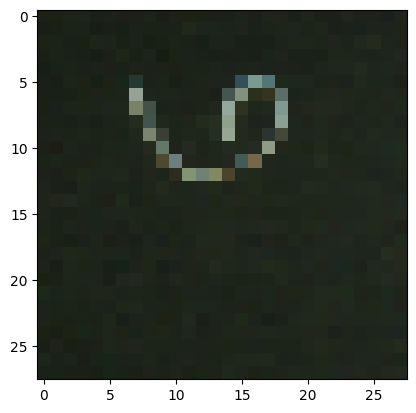

In [444]:
images = getImages('data/training-a.csv')
labels = getLabels('data/training-a.csv')
# # images.append(image)
# # labels.append(label)
# image += getImages('data/training-b')
# label += getLabels('data/training-b.csv')
# # images.append(image)
# # labels.append(label)


# one hot encode
labels = np.eye(10)[labels].astype(int)
print(images.shape)
print(labels.shape)
# view an image
plt.imshow(images[1].transpose(1, 2, 0))
print(labels[1])


In [445]:
# initialize model
model = createModel()

model created:  [<__main__.ConvolutionLayer object at 0x7fe9e43d9dc0>, <__main__.ReLULayer object at 0x7fe9e43d95e0>, <__main__.MaxPoolingLayer object at 0x7fe9e43d9f40>, <__main__.ConvolutionLayer object at 0x7fe9e43d9610>, <__main__.ReLULayer object at 0x7fe9e43d96d0>, <__main__.MaxPoolingLayer object at 0x7fe9e43d9f70>, <__main__.FlatteningLayer object at 0x7fe9e43d9c10>, <__main__.FullyConnectedLayer object at 0x7fe9e43d9a90>, <__main__.SoftmaxLayer object at 0x7fe9e43d94f0>]


In [446]:
# train model

X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)


(800, 3, 28, 28)
(200, 3, 28, 28)
(800, 10)
(200, 10)


In [447]:
train(model, X_train, X_test, Y_train, Y_test, 0.01, 30)

epoch: 1/30


100%|██████████| 25/25 [00:13<00:00,  1.82it/s]


loss: 2.3660711740043108, val_loss: 2.323368277151544
accuracy: 0.10875, val_accuracy: 0.09
val_F1: 0.04290414547696101
epoch: 2/30


100%|██████████| 25/25 [00:14<00:00,  1.75it/s]


loss: 2.3185451613580397, val_loss: 2.2987165761515103
accuracy: 0.095, val_accuracy: 0.1
val_F1: 0.06851973404049863
epoch: 3/30


100%|██████████| 25/25 [00:14<00:00,  1.76it/s]


loss: 2.3005832662592325, val_loss: 2.285759207654824
accuracy: 0.10625, val_accuracy: 0.11
val_F1: 0.0788634284371699
epoch: 4/30


100%|██████████| 25/25 [00:14<00:00,  1.68it/s]


loss: 2.2882623648328178, val_loss: 2.27641005571535
accuracy: 0.12125, val_accuracy: 0.145
val_F1: 0.11269230769230769
epoch: 5/30


100%|██████████| 25/25 [00:14<00:00,  1.68it/s]


loss: 2.2782869726510517, val_loss: 2.2687038877348384
accuracy: 0.135, val_accuracy: 0.16
val_F1: 0.12555096406148297
epoch: 6/30


100%|██████████| 25/25 [00:14<00:00,  1.72it/s]


loss: 2.269223028030822, val_loss: 2.2617990865037
accuracy: 0.15375, val_accuracy: 0.165
val_F1: 0.12952898503050478
epoch: 7/30


100%|██████████| 25/25 [00:14<00:00,  1.72it/s]


loss: 2.260530905705243, val_loss: 2.2547761525101873
accuracy: 0.1775, val_accuracy: 0.19
val_F1: 0.14839634099253735
epoch: 8/30


100%|██████████| 25/25 [00:14<00:00,  1.69it/s]


loss: 2.251655610168555, val_loss: 2.2470460902134395
accuracy: 0.195, val_accuracy: 0.205
val_F1: 0.15895468223459835
epoch: 9/30


100%|██████████| 25/25 [00:14<00:00,  1.71it/s]


loss: 2.242097321125472, val_loss: 2.2382693616249894
accuracy: 0.21125, val_accuracy: 0.23
val_F1: 0.17920388411929894
epoch: 10/30


100%|██████████| 25/25 [00:14<00:00,  1.73it/s]


loss: 2.231801866201265, val_loss: 2.2287016688052472
accuracy: 0.22625, val_accuracy: 0.225
val_F1: 0.17446293014289227
epoch: 11/30


100%|██████████| 25/25 [00:15<00:00,  1.65it/s]


loss: 2.220439411578354, val_loss: 2.2180293340887234
accuracy: 0.24, val_accuracy: 0.26
val_F1: 0.2158326265977335
epoch: 12/30


100%|██████████| 25/25 [00:15<00:00,  1.64it/s]


loss: 2.2076755674391846, val_loss: 2.206455460208218
accuracy: 0.25125, val_accuracy: 0.26
val_F1: 0.21258432532468685
epoch: 13/30


100%|██████████| 25/25 [00:14<00:00,  1.68it/s]


loss: 2.1930719373166414, val_loss: 2.1936676252268548
accuracy: 0.255, val_accuracy: 0.27
val_F1: 0.22278586859788296
epoch: 14/30


100%|██████████| 25/25 [00:14<00:00,  1.70it/s]


loss: 2.1766765943445368, val_loss: 2.179512509572054
accuracy: 0.2575, val_accuracy: 0.27
val_F1: 0.222796066252588
epoch: 15/30


100%|██████████| 25/25 [00:16<00:00,  1.56it/s]


loss: 2.159011315692948, val_loss: 2.1640247301191886
accuracy: 0.2675, val_accuracy: 0.28
val_F1: 0.23691393049697407
epoch: 16/30


100%|██████████| 25/25 [00:14<00:00,  1.68it/s]


loss: 2.139888997380875, val_loss: 2.1475517775898734
accuracy: 0.2825, val_accuracy: 0.29
val_F1: 0.24693713263480704
epoch: 17/30


100%|██████████| 25/25 [00:14<00:00,  1.67it/s]


loss: 2.118928310750239, val_loss: 2.129397226139795
accuracy: 0.2925, val_accuracy: 0.3
val_F1: 0.26154612738086247
epoch: 18/30


100%|██████████| 25/25 [00:15<00:00,  1.66it/s]


loss: 2.0960238693739455, val_loss: 2.11018371502504
accuracy: 0.30125, val_accuracy: 0.305
val_F1: 0.2674860988814477
epoch: 19/30


100%|██████████| 25/25 [00:14<00:00,  1.70it/s]


loss: 2.0709458680142805, val_loss: 2.088794378767815
accuracy: 0.3175, val_accuracy: 0.315
val_F1: 0.27930607117913614
epoch: 20/30


100%|██████████| 25/25 [00:14<00:00,  1.69it/s]


loss: 2.0440972308123824, val_loss: 2.0653812683130113
accuracy: 0.3275, val_accuracy: 0.325
val_F1: 0.2896924873085863
epoch: 21/30


100%|██████████| 25/25 [00:14<00:00,  1.70it/s]


loss: 2.015401199847236, val_loss: 2.0406958640611803
accuracy: 0.33625, val_accuracy: 0.34
val_F1: 0.30333774469258334
epoch: 22/30


100%|██████████| 25/25 [00:14<00:00,  1.72it/s]


loss: 1.9847857486858793, val_loss: 2.0143137263175817
accuracy: 0.35125, val_accuracy: 0.345
val_F1: 0.30612899516292574
epoch: 23/30


100%|██████████| 25/25 [00:14<00:00,  1.67it/s]


loss: 1.9523210117478484, val_loss: 1.9860741605890195
accuracy: 0.35875, val_accuracy: 0.355
val_F1: 0.3087231450595029
epoch: 24/30


100%|██████████| 25/25 [00:14<00:00,  1.70it/s]


loss: 1.9180659389696344, val_loss: 1.9558070194121637
accuracy: 0.37125, val_accuracy: 0.36
val_F1: 0.3108515859331688
epoch: 25/30


100%|██████████| 25/25 [00:14<00:00,  1.70it/s]


loss: 1.8817344110052818, val_loss: 1.9232567717982396
accuracy: 0.39, val_accuracy: 0.37
val_F1: 0.3277540462677596
epoch: 26/30


100%|██████████| 25/25 [00:14<00:00,  1.72it/s]


loss: 1.8437170022692602, val_loss: 1.8889498184170446
accuracy: 0.39375, val_accuracy: 0.38
val_F1: 0.33736603836830154
epoch: 27/30


100%|██████████| 25/25 [00:14<00:00,  1.68it/s]


loss: 1.8041134592492312, val_loss: 1.8529777243171839
accuracy: 0.40875, val_accuracy: 0.39
val_F1: 0.3480261643694277
epoch: 28/30


100%|██████████| 25/25 [00:15<00:00,  1.67it/s]


loss: 1.7631932293442185, val_loss: 1.8150253924588833
accuracy: 0.41875, val_accuracy: 0.395
val_F1: 0.3499130934425052
epoch: 29/30


100%|██████████| 25/25 [00:14<00:00,  1.71it/s]


loss: 1.7215174714795143, val_loss: 1.776934543343101
accuracy: 0.435, val_accuracy: 0.395
val_F1: 0.3494079610612424
epoch: 30/30


100%|██████████| 25/25 [00:14<00:00,  1.67it/s]


loss: 1.680025297567052, val_loss: 1.7387333844907722
accuracy: 0.44125, val_accuracy: 0.41
val_F1: 0.36106897025185936
